# Diffractive and Non- Diffractive ODT Reconstruction Simulations

This code simulate the non-diffracting tomographic reconstruction of an object using filtered backprojection and Fourier interpolation. We will late also compare with diffraction algorithms.

In [9]:
import numpy as np
import matplotlib.pylab as plt
import scipy as sp
from time import time
from mpl_toolkits import mplot3d
from IPython.display import display, Latex
from skimage.transform import radon, rescale, iradon
from scipy.interpolate import griddata
from scipy.ndimage import rotate
import plotly.graph_objects as go

This script generates a 3D cylinder, texture, artifacts and noise can be later added on the basic shape. We also generate detector's plan and set projection number.

In [2]:
N = 250                                     # Grid size
a = 1.5e-3                                  # Cylinder main axis (radius in xy)
b = 2e-3                                    # Cylinder secondary axis (radius in xy)
height = 5e-3                               # Cylinder height along z
L = 10e-3                                   # Object field of view [m]
n_obj = 1.38                                # Refractive index of the object
n_med = 1.33                                # Refractive index of the medium
wavelength = 532e-9                         # Wavelength [m]
num_projections = 128                       # Number of projections

# set up the 3D voxel grid
deltax = L/N
x = deltax * np.linspace(-N/2, (N/2)-1, N)
y = x
z = np.linspace(-height/2, height/2, N)  # or N_z if different resolution along z
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')

# For cylinder along z-axis
# Mask of points inside cylinder
cylinder_mask = (xx/a)**2 + (yy/b)**2 <= 1

# 3D object
object3D = np.zeros_like(xx)
object3D[cylinder_mask] = n_obj  


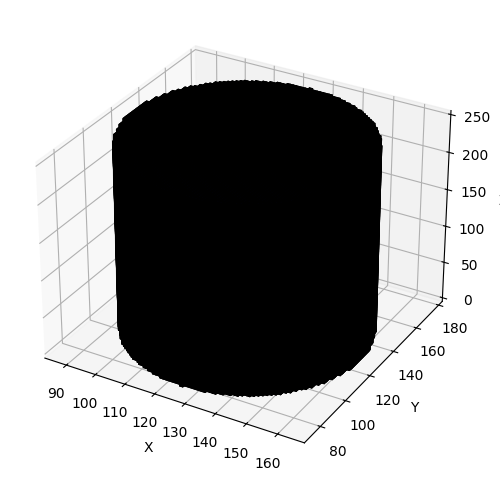

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

# Make a boolean mask of the cylinder
mask = object3D > 0  

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot voxels
ax.voxels(mask, facecolors='blue', edgecolor='k', alpha=0.3)  # alpha makes it semi-transparent

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()




Acquiring projections: 

In [ ]:
angles = np.linspace(0, 360, num_projections, endpoint=False)
projections = []
for angle in angles:
    rotated = rotate(object3D, angle, axes=(0,1), reshape=False, order=1)  # rotate in x-z plane -> around y
    proj = np.sum(rotated, axis=0) * deltax  # sum along x; result shape (Ny, Nz)
    projections.append(proj)
sinogram3D = np.stack(projections, axis=0)  # shape (n_angles, Ny, Nz)



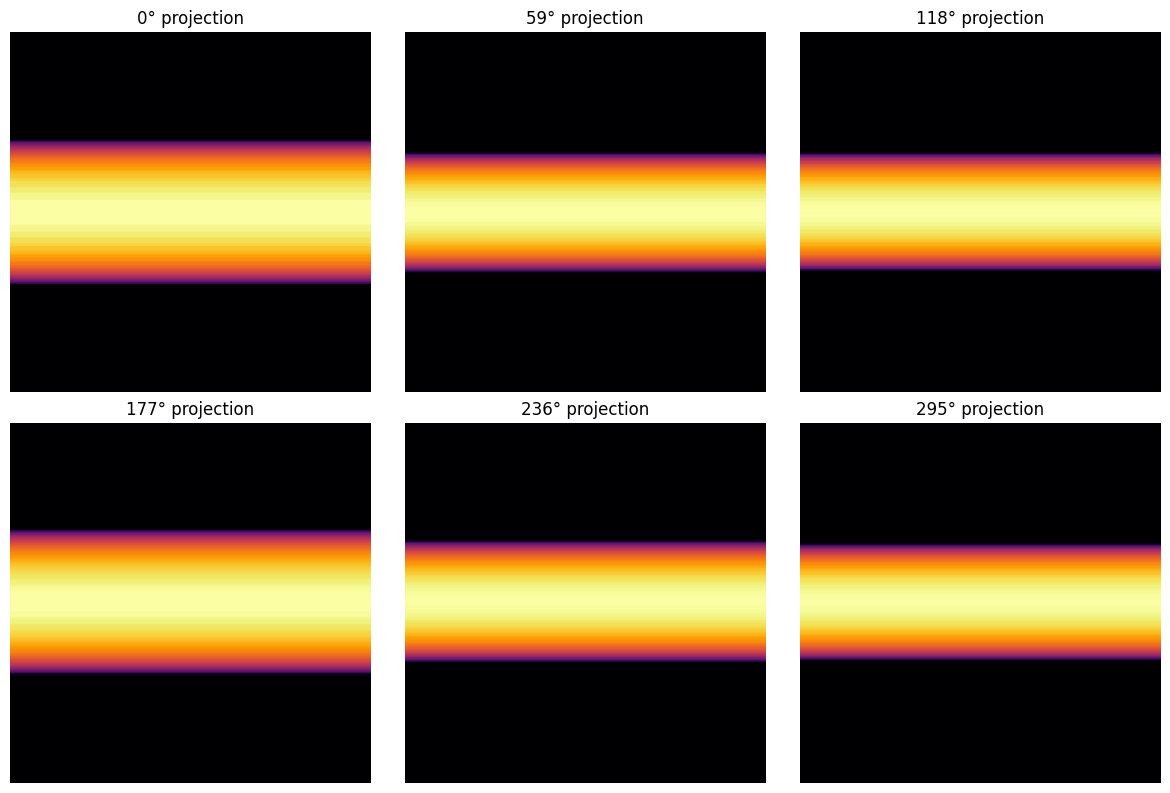

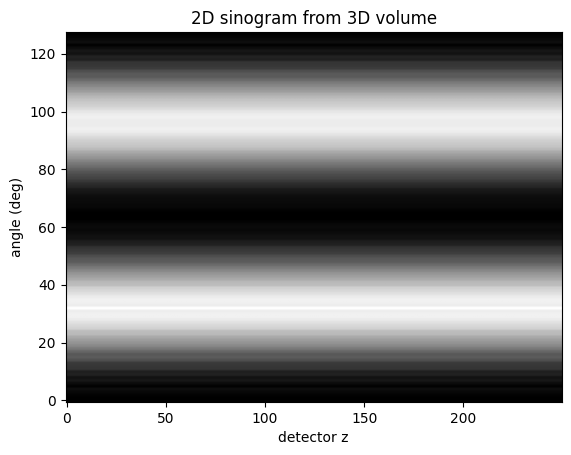

In [33]:

num_samples = 6  # number of projections to display
step = len(projections) // num_samples
indices = np.arange(0, len(projections), step)[:num_samples]  # evenly spaced

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for ax, idx in zip(axs.ravel(), indices):
    ax.imshow(projections[idx], cmap='inferno')
    ax.set_title(f"{angles[idx]:.0f}° projection")
    ax.axis('off')
plt.tight_layout()
plt.show()

mid_y = sinogram3D.shape[1] // 2
sinogram2D = sinogram3D[:, mid_y, :]  # shape: (n_angles, Nz)

import matplotlib.pyplot as plt
plt.imshow(sinogram2D, cmap='gray', aspect='auto', origin='lower')
plt.xlabel('detector z')
plt.ylabel('angle (deg)')
plt.title('2D sinogram from 3D volume')
plt.show()



Texture

changing n -gradually

coexentric

calculate projections?

iradon

fft approach

noise

odt-brain

for ODT- pipeline, add phase unwrapping



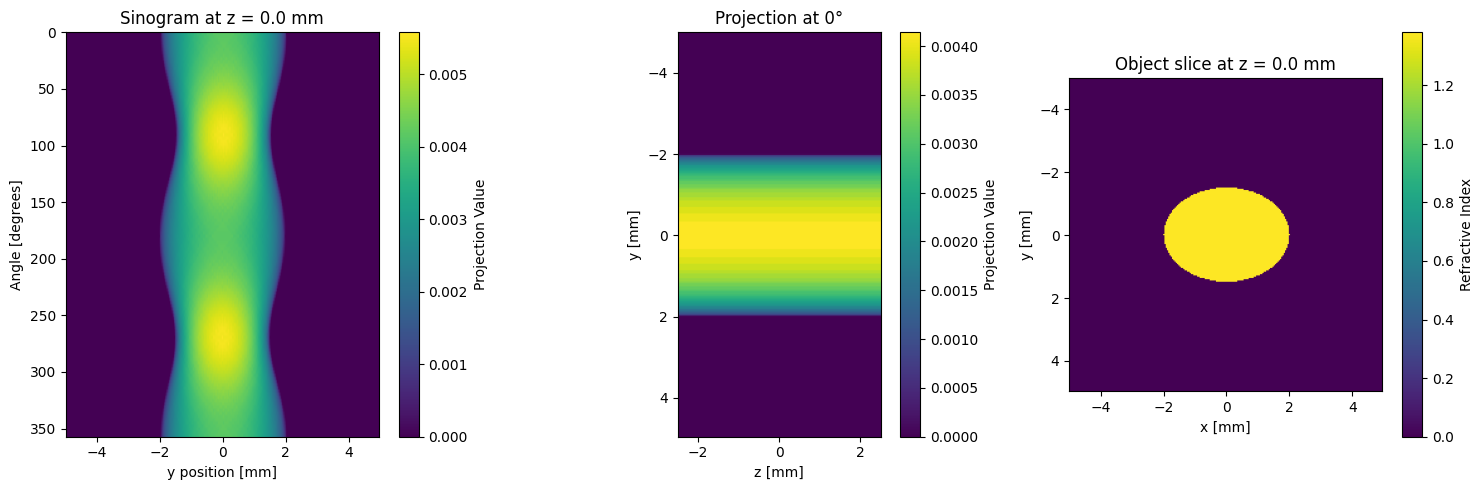

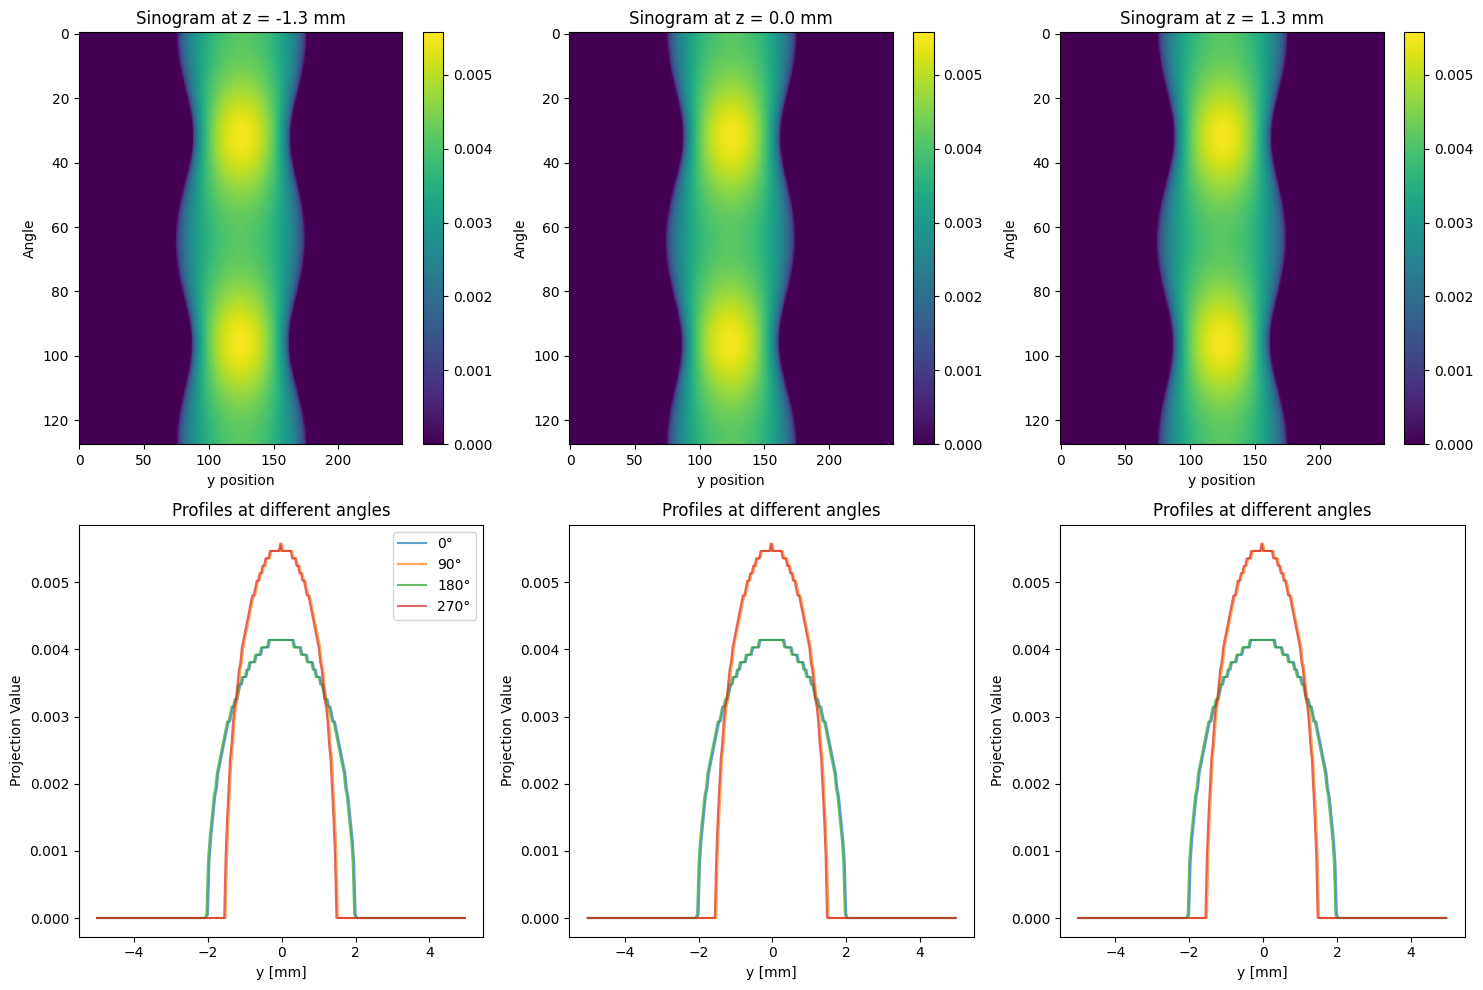

In [34]:
import matplotlib.pyplot as plt

# After you generate your sinogram3D...

# Plot 1: Show a slice at fixed z-position
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Take a slice through the middle of the z-axis
z_slice = sinogram3D.shape[2] // 2
sinogram_slice = sinogram3D[:, :, z_slice]

# Plot the sinogram slice
im1 = axes[0].imshow(sinogram_slice, cmap='viridis', aspect='auto', 
                    extent=[y[0]*1e3, y[-1]*1e3, angles[-1], angles[0]])
axes[0].set_xlabel('y position [mm]')
axes[0].set_ylabel('Angle [degrees]')
axes[0].set_title(f'Sinogram at z = {z[z_slice]*1e3:.1f} mm')
plt.colorbar(im1, ax=axes[0], label='Projection Value')

# Plot 2: Show one projection (at angle 0)
im2 = axes[1].imshow(projections[0], cmap='viridis', 
                    extent=[z[0]*1e3, z[-1]*1e3, y[-1]*1e3, y[0]*1e3])
axes[1].set_xlabel('z [mm]')
axes[1].set_ylabel('y [mm]')
axes[1].set_title(f'Projection at 0°')
plt.colorbar(im2, ax=axes[1], label='Projection Value')

# Plot 3: Show the 3D object slice for reference
z_obj_slice = object3D.shape[2] // 2
im3 = axes[2].imshow(object3D[:, :, z_obj_slice], cmap='viridis',
                    extent=[x[0]*1e3, x[-1]*1e3, y[-1]*1e3, y[0]*1e3])
axes[2].set_xlabel('x [mm]')
axes[2].set_ylabel('y [mm]')
axes[2].set_title(f'Object slice at z = {z[z_obj_slice]*1e3:.1f} mm')
plt.colorbar(im3, ax=axes[2], label='Refractive Index')

plt.tight_layout()
plt.show()

# Additional plot: Show multiple z-slices to see the pattern
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
z_positions = [sinogram3D.shape[2]//4, sinogram3D.shape[2]//2, 3*sinogram3D.shape[2]//4]

for i, z_pos in enumerate(z_positions):
    # Top row: sinogram slices
    im_top = axes[0, i].imshow(sinogram3D[:, :, z_pos], cmap='viridis', aspect='auto')
    axes[0, i].set_title(f'Sinogram at z = {z[z_pos]*1e3:.1f} mm')
    axes[0, i].set_xlabel('y position')
    axes[0, i].set_ylabel('Angle')
    plt.colorbar(im_top, ax=axes[0, i])
    
    # Bottom row: horizontal profiles at different angles
    for angle_idx in [0, len(angles)//4, len(angles)//2, 3*len(angles)//4]:
        axes[1, i].plot(y*1e3, sinogram3D[angle_idx, :, z_pos], 
                       label=f'{angles[angle_idx]:.0f}°', alpha=0.7)
    axes[1, i].set_xlabel('y [mm]')
    axes[1, i].set_ylabel('Projection Value')
    axes[1, i].set_title(f'Profiles at different angles')
    if i == 0:
        axes[1, i].legend()

plt.tight_layout()
plt.show()

In [20]:
# choose axis config that showed change above (example: rotate around y, sum along x)
angles = np.linspace(0, 180, num_projections, endpoint=False)
projections = []
for angle in angles:
    rotated = rotate(object3D, angle, axes=(0,2), reshape=False, order=1)  # rotate in x-z plane -> around y
    proj = np.sum(rotated, axis=0) * deltax  # sum along x; result shape (Ny, Nz)
    projections.append(proj)
sinogram3d = np.stack(projections, axis=0)  # shape (n_angles, Ny, Nz)


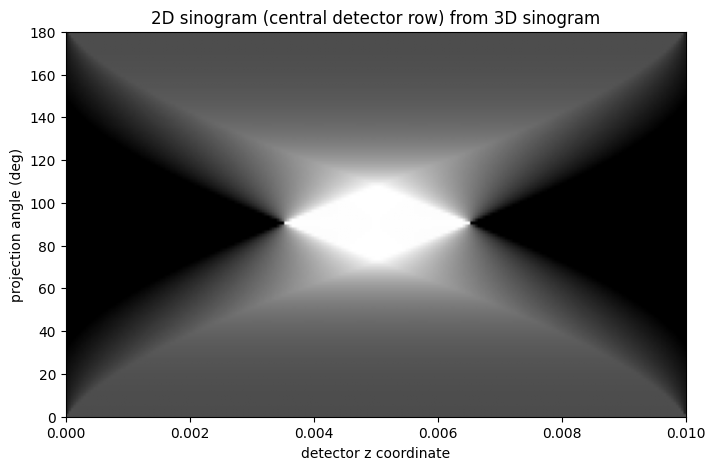

In [21]:
mid_y = sinogram3d.shape[1] // 2
sinogram2D = sinogram3d[:, mid_y, :]   # shape (n_angles, Nz)

plt.figure(figsize=(8,5))
plt.imshow(sinogram2D, cmap='gray', aspect='auto', origin='lower',
           extent=[0, L, 0, 180])  # extent: (z_min, z_max, angle_min, angle_max)
plt.xlabel('detector z coordinate')
plt.ylabel('projection angle (deg)')
plt.title('2D sinogram (central detector row) from 3D sinogram')
plt.show()
